## Loading Required Libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from urllib.request import urlopen
import json
import requests
import re
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Displaying static image https://plotly.com/python/orca-management/
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [3]:
confirmed_color = 'navy'
recovered_color = 'green'
death_color = 'indianred'
active_color = 'purple'

## Dataset Source and Credit
* https://api.covid19india.org/

In [4]:
df1 = "https://api.covid19india.org/state_district_wise.json"
df2 = "https://api.covid19india.org/data.json"

In [5]:
def getting_data(url):
    response = requests.get(url)
    data = response.content.decode('utf-8')
    return data

In [6]:
df_state = json.loads(getting_data(df1))
df = json.loads(getting_data(df2))

In [7]:
lis = []
state_names = df_state.keys()
for state in state_names:
    district_names = df_state[state]['districtData'].keys() #Districts of Current State
    for district in district_names:
        temp = df_state[state]['districtData'][district]
        var_lis = [state,district,temp.get('confirmed'),temp.get('recovered'),
                   temp.get('active'),temp.get('deceased')]
        lis.append(var_lis)
    district_wise = pd.DataFrame(lis,columns=['State/UT','District','Confirmed',
                                              'Recovered','Active','Death'])
district_wise.head()

,State/UT,District,Confirmed,Recovered,Active,Death
0,State Unassigned,Unassigned,0,0,0,0
1,Andaman and Nicobar Islands,Nicobars,0,0,0,0
2,Andaman and Nicobar Islands,North and Middle Andaman,1,1,0,0
3,Andaman and Nicobar Islands,South Andaman,51,32,19,0
4,Andaman and Nicobar Islands,Unknown,1071,322,733,16


In [8]:
temp = [[i['state'],i['confirmed'],i['recovered'],i['active'],i['deaths'],
         i['lastupdatedtime']] for i in df['statewise']]
statewise_total = pd.DataFrame(temp,columns=['State/UT','Confirmed','Recovered',
                                          'Active','Death','LastUpdateTime'])
statewise_total.head()

,State/UT,Confirmed,Recovered,Active,Death,LastUpdateTime
0,Total,2021407,1374420,604906,41627,06/08/2020 21:24:39
1,Maharashtra,479779,316375,146305,16792,06/08/2020 20:42:51
2,Tamil Nadu,279144,221087,53486,4571,06/08/2020 19:44:47
3,Delhi,141531,127124,10348,4059,06/08/2020 18:39:45
4,Karnataka,158254,80281,75067,2897,06/08/2020 21:19:51


In [9]:
statewise_total['Confirmed']=statewise_total['Confirmed'].astype('int')
statewise_total['Recovered']=statewise_total['Recovered'].astype('int')
statewise_total['Active']=statewise_total['Active'].astype('int')
statewise_total['Death']=statewise_total['Death'].astype('int')
statewise_total['RecoveryRate%'] = round(statewise_total['Recovered']/statewise_total['Confirmed']*100,2)
statewise_total['MortalityRate%'] = round(statewise_total['Death']/statewise_total['Confirmed']*100,2)
statewise_total['Active/100 Confirmed'] = round(statewise_total['Active']/statewise_total['Confirmed']*100,2)
for i,y in enumerate(statewise_total['LastUpdateTime']):
    statewise_total['LastUpdateTime'][i] = pd.to_datetime(y.split(' ')[0])
statewise_total['LastUpdateTime'] = pd.to_datetime(statewise_total['LastUpdateTime'])
statewise_total.head()

,State/UT,Confirmed,Recovered,Active,Death,LastUpdateTime,RecoveryRate%,MortalityRate%,Active/100 Confirmed
0,Total,2021407,1374420,604906,41627,2020-06-08,67.99,2.06,29.92
1,Maharashtra,479779,316375,146305,16792,2020-06-08,65.94,3.50,30.49
2,Tamil Nadu,279144,221087,53486,4571,2020-06-08,79.20,1.64,19.16
3,Delhi,141531,127124,10348,4059,2020-06-08,89.82,2.87,7.31
4,Karnataka,158254,80281,75067,2897,2020-06-08,50.73,1.83,47.43


In [10]:
timeseries = [list(i.values()) for i in df['cases_time_series']]
timeseries = pd.DataFrame(timeseries,columns=df['cases_time_series'][0].keys())
timeseries.head()

,dailyconfirmed,dailydeceased,dailyrecovered,date,totalconfirmed,totaldeceased,totalrecovered
0,1,0,0,30 January,1,0,0
1,0,0,0,31 January,1,0,0
2,0,0,0,01 February,1,0,0
3,1,0,0,02 February,2,0,0
4,1,0,0,03 February,3,0,0


In [11]:
timeseries['dailyconfirmed'] = timeseries['dailyconfirmed'].astype('int')
timeseries['dailydeceased'] = timeseries['dailydeceased'].astype('int')
timeseries['dailyrecovered'] = timeseries['dailyrecovered'].astype('int')
timeseries['totalconfirmed'] = timeseries['totalconfirmed'].astype('int')
timeseries['totaldeceased'] = timeseries['totaldeceased'].astype('int')
timeseries['totalrecovered'] = timeseries['totalrecovered'].astype('int')
timeseries['7dyMnConfirmed'] = timeseries.totalconfirmed.rolling(7).mean().fillna(0).astype(int)
timeseries['7dyMnRecovered'] = timeseries.totalrecovered.rolling(7).mean().fillna(0).astype(int)
timeseries['7dyMnDeceased'] = timeseries.totaldeceased.rolling(7).mean().fillna(0).astype(int)
timeseries.head(10)

,dailyconfirmed,dailydeceased,dailyrecovered,date,totalconfirmed,totaldeceased,totalrecovered,7dyMnConfirmed,7dyMnRecovered,7dyMnDeceased
0,1,0,0,30 January,1,0,0,0,0,0
1,0,0,0,31 January,1,0,0,0,0,0
2,0,0,0,01 February,1,0,0,0,0,0
3,1,0,0,02 February,2,0,0,0,0,0
4,1,0,0,03 February,3,0,0,0,0,0
5,0,0,0,04 February,3,0,0,0,0,0
6,0,0,0,05 February,3,0,0,2,0,0
7,0,0,0,06 February,3,0,0,2,0,0
8,0,0,0,07 February,3,0,0,2,0,0
9,0,0,0,08 February,3,0,0,2,0,0


In [12]:
values = [list(i.values())[-5:] for i in df["tested"]]
tests = pd.DataFrame(values, columns=list(df["tested"][0].keys())[-5:])
for i,value in enumerate(tests['totalsamplestested']):
    if value=='':
      avg = math.ceil((int(tests['totalsamplestested'].iloc[i-1])+int(tests['totalsamplestested'].iloc[i+1]))/2)
      tests['totalsamplestested'].iloc[i] = avg #Taking avg from previous and next value for three missing values
tests['totalsamplestested'] = tests['totalsamplestested'].astype('int')
for i,value in enumerate(tests['testspermillion']):
    if value=='':
      avg = math.ceil((int(tests['testspermillion'].iloc[i-1])+int(tests['testspermillion'].iloc[i+1]))/2)
      tests['testspermillion'].iloc[i] = avg #Taking avg from previous and next value for three missing values
tests['testspermillion'] = tests['testspermillion'].astype('int')
#tests.head()

In [13]:
time_series_state = pd.read_csv('https://api.covid19india.org/csv/latest'
                                        '/state_wise_daily.csv')
del time_series_state['TT']
time_series_state = time_series_state.melt(id_vars=['Status','Date'], 
                      value_vars=time_series_state.columns[2:],
                      value_name='Census',var_name='State')
time_series_state = time_series_state.pivot_table(index=['Date', 'State'], 
                                                columns=['Status'], 
                                                values='Census')
time_series_state = time_series_state.reset_index()

In [14]:
given_data = json.loads(getting_data(df1))
state_names = given_data.keys()
given_lis = []
for state in state_names:
    #district_names = df_state[state]['statecode'].keys() 
    #print(a[state]['statecode'],state)
    given_lis.append([given_data[state]['statecode'],state])
given_dic = {}
for i in given_lis:
    given_dic[i[0]] = i[1]
given_dic['DD'] = 'Daman and Diu'
#code = pd.DataFrame(given_dic.items(),columns={'Code','State'})
time_series_state['State-Name'] = time_series_state['State'].map(given_dic)
time_series_state['Date'] = pd.to_datetime(time_series_state['Date'])
time_series_state.set_index('Date',inplace=True)
#time_series_state.head()

## Total Cases in India

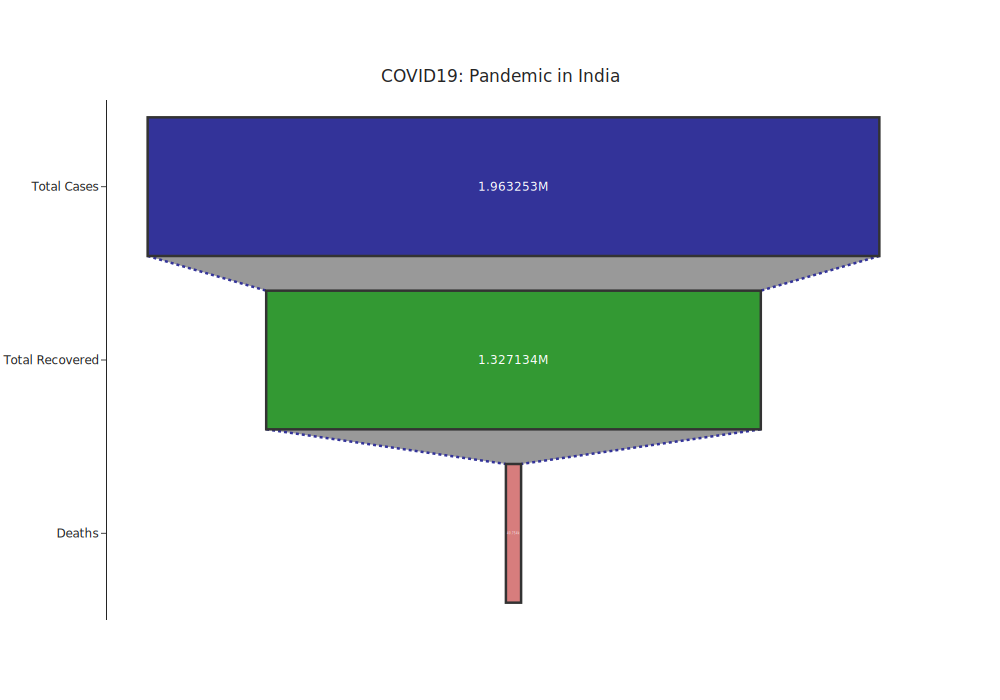

In [17]:
fig = go.Figure(go.Funnel(
    x = [timeseries['totalconfirmed'].iloc[-1],timeseries['totalrecovered'].iloc[-1],
         timeseries['totaldeceased'].iloc[-1]],
    y = ["Total Cases", "Total Recovered",  "Deaths"],
    textposition = "inside",
    textinfo = "value",
    opacity = 0.8, 
    marker = {"color": [confirmed_color,recovered_color,death_color],
              "line": {"width": 2.5, "color": 'Black'}},
    connector = {"line": {"color": "navy", "dash": "dot", "width": 2.5}}))
fig.update_layout(
    template="simple_white",
    title={'text': "COVID19: Pandemic in India",'x':0.5,'y':0.9,       
        'xanchor': 'center','yanchor': 'top'})
fig.update_layout(height=700)
fig.show()
fig.show('svg',height = 700, width = 1000) #static image

## Statewise Cases in India

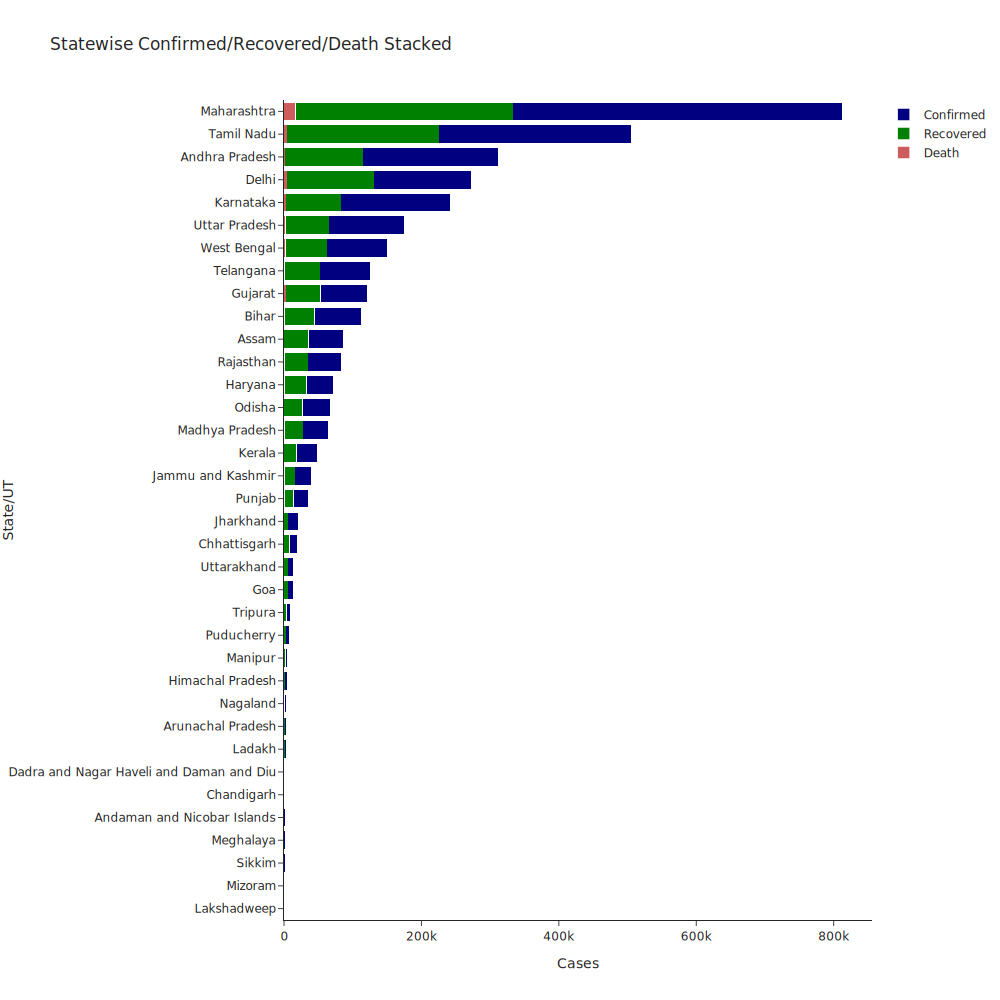

In [18]:
temp = statewise_total[statewise_total['State/UT']!='Total']
temp = temp[temp['State/UT']!='State Unassigned']
fig = go.Figure(data=[
    go.Bar(name='Death', y=temp['State/UT'], x=temp['Death'],orientation='h',marker_color=death_color),
    go.Bar(name='Recovered', y=temp['State/UT'], x=temp['Recovered'],orientation='h',marker_color=recovered_color),
    go.Bar(name='Confirmed', y=temp['State/UT'], x=temp['Confirmed'],orientation='h',marker_color=confirmed_color)
])
fig.update_layout(barmode='stack',title='Statewise Confirmed/Recovered/Death Stacked', xaxis_title="Cases", yaxis_title="State/UT", 
                      yaxis_categoryorder = 'total ascending', height = 1000,
                      template='simple_white')
fig.show()
fig.show('svg',height = 1000, width = 1000) #static image

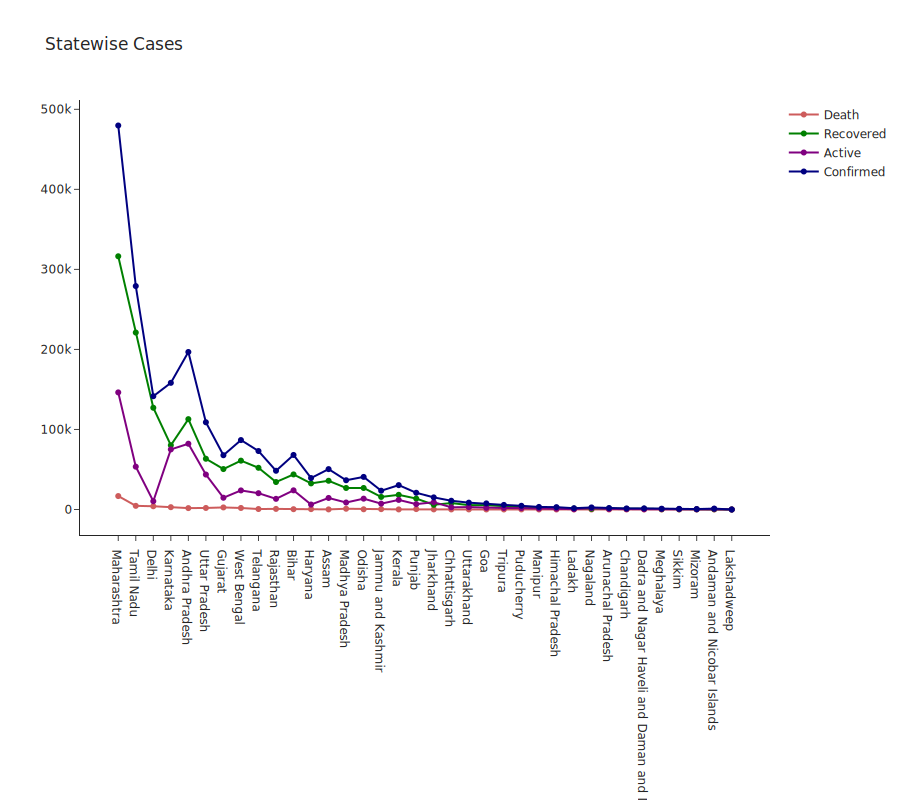

In [26]:
temp = statewise_total[statewise_total['State/UT']!='Total']
temp = temp[temp['State/UT']!='State Unassigned']
fig = go.Figure()
fig.add_trace(go.Scatter(y=temp['Death'], x=temp['State/UT'],
                    mode='lines+markers',
                    name='Death',marker_color=death_color))
fig.add_trace(go.Scatter(y=temp['Recovered'], x=temp['State/UT'],
                    mode='lines+markers',
                    name='Recovered',marker_color=recovered_color))
fig.add_trace(go.Scatter(y=temp['Active'], x=temp['State/UT'],
                    mode='lines+markers', name='Active',marker_color=active_color))
fig.add_trace(go.Scatter(y=temp['Confirmed'], x=temp['State/UT'],
                    mode='lines+markers', name='Confirmed',marker_color=confirmed_color))
fig.update_layout(height=900,width= 1200, title_text="Statewise Cases",template='simple_white')
fig.show()
fig.show('svg',height = 800, width = 900) #static image

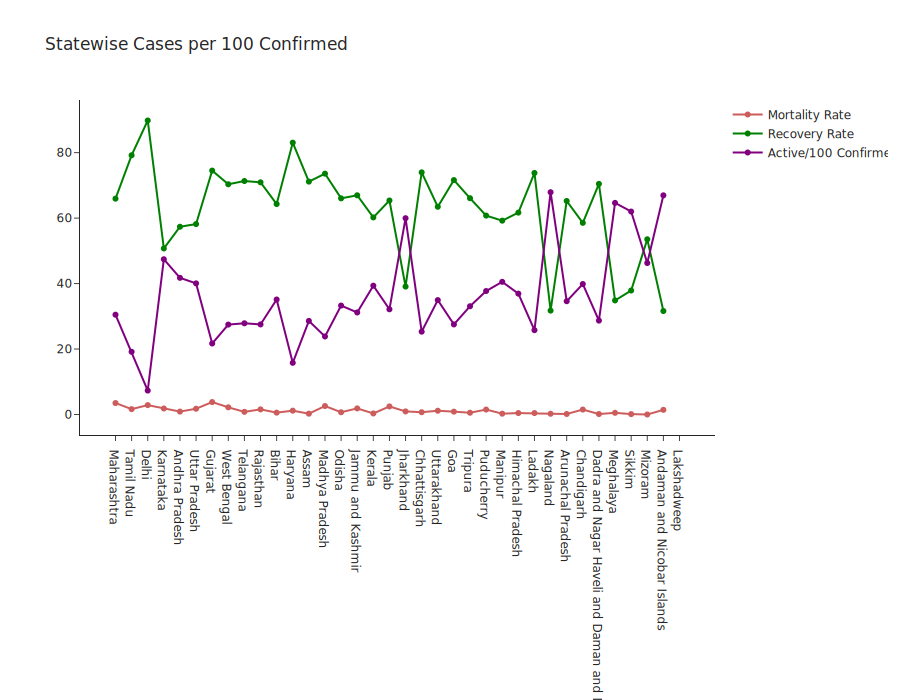

In [25]:
temp = statewise_total[statewise_total['State/UT']!='Total']
temp = temp[temp['State/UT']!='State Unassigned']
fig = go.Figure()
fig.add_trace(go.Scatter(y=temp['MortalityRate%'], x=temp['State/UT'],
                    mode='lines+markers',
                    name='Mortality Rate',marker_color=death_color))
fig.add_trace(go.Scatter(y=temp['RecoveryRate%'], x=temp['State/UT'],
                    mode='lines+markers',
                    name='Recovery Rate',marker_color=recovered_color))
fig.add_trace(go.Scatter(y=temp['Active/100 Confirmed'], x=temp['State/UT'],
                    mode='lines+markers', name='Active/100 Confirmed',marker_color=active_color))
fig.update_layout(height=700,width= 1200, title_text="Statewise Cases per 100 Confirmed",template='simple_white')
fig.show()
fig.show('svg',height = 700, width = 900) #static image

## Total cases in India Analysis with 7-day Average

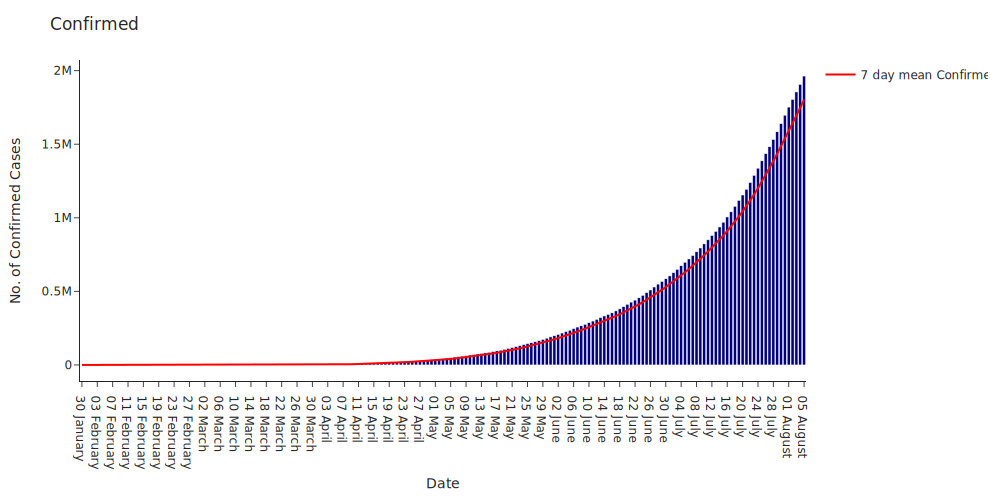

In [30]:
fig = px.bar(timeseries, x='date', y='totalconfirmed', color_discrete_sequence=[confirmed_color],template='simple_white')
fig.update_layout(title='Confirmed', xaxis_title="Date", yaxis_title="No. of Confirmed Cases")
fig.add_scatter(x=timeseries['date'],y=timeseries['7dyMnConfirmed'],name='7 day mean Confirmed',
                marker={'color': 'red','opacity': 0.6,'colorscale': 'Viridis'},)
fig.show()
fig.show('svg',height = 500, width = 1000) #static image

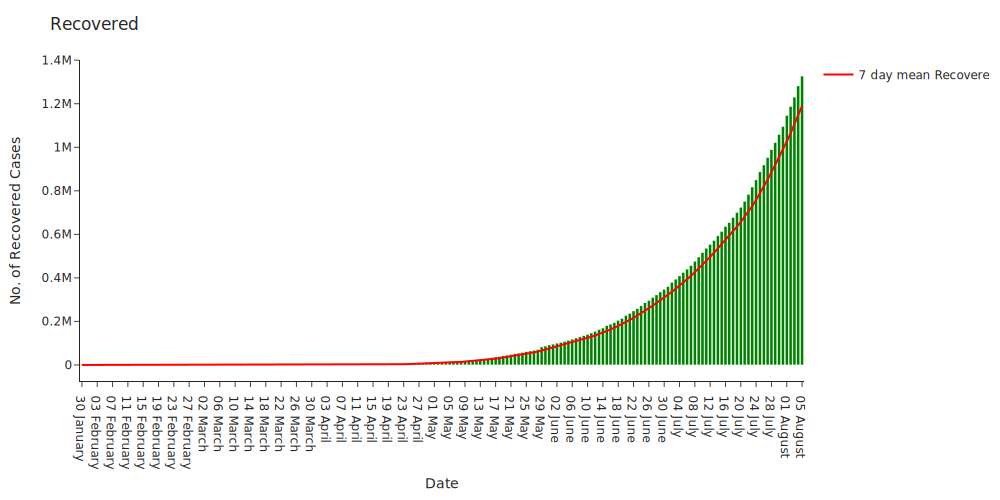

In [31]:
fig = px.bar(timeseries, x='date', y='totalrecovered', 
             color_discrete_sequence=[recovered_color],template='simple_white')
fig.update_layout(title='Recovered', xaxis_title="Date", yaxis_title="No. of Recovered Cases")
fig.add_scatter(x=timeseries['date'],y=timeseries['7dyMnRecovered'],name='7 day mean Recovered',
                marker={'color': 'red','opacity': 0.6,'colorscale': 'Viridis'},)
fig.show()
fig.show('svg',height = 500, width = 1000) #static image


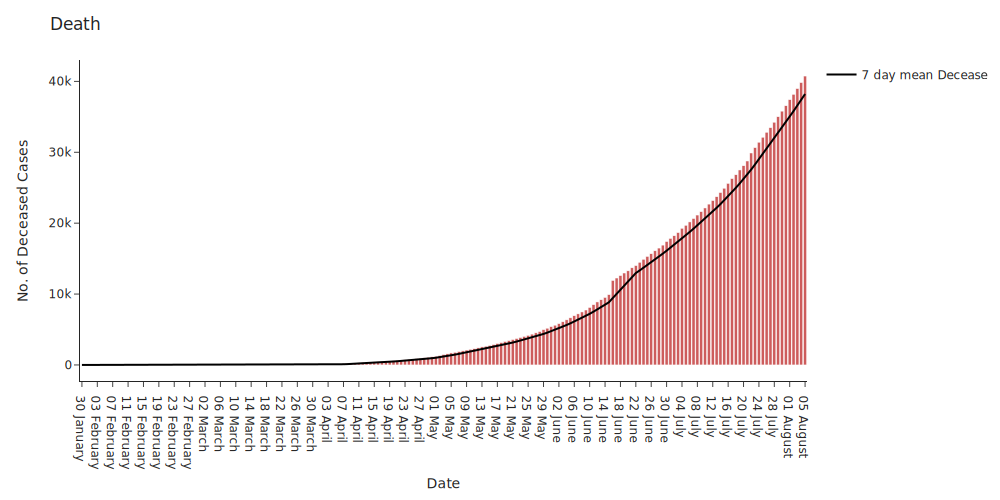

In [32]:
fig = px.bar(timeseries, x='date', y='totaldeceased', 
             color_discrete_sequence=[death_color],template='simple_white')
fig.update_layout(title='Death', xaxis_title="Date", yaxis_title="No. of Deceased Cases")
fig.add_scatter(x=timeseries['date'],y=timeseries['7dyMnDeceased'],name='7 day mean Deceased',
                marker={'color': 'black','opacity': 0.6,'colorscale': 'Viridis'},)
fig.show()
fig.show('svg',height = 500, width = 1000) #static image

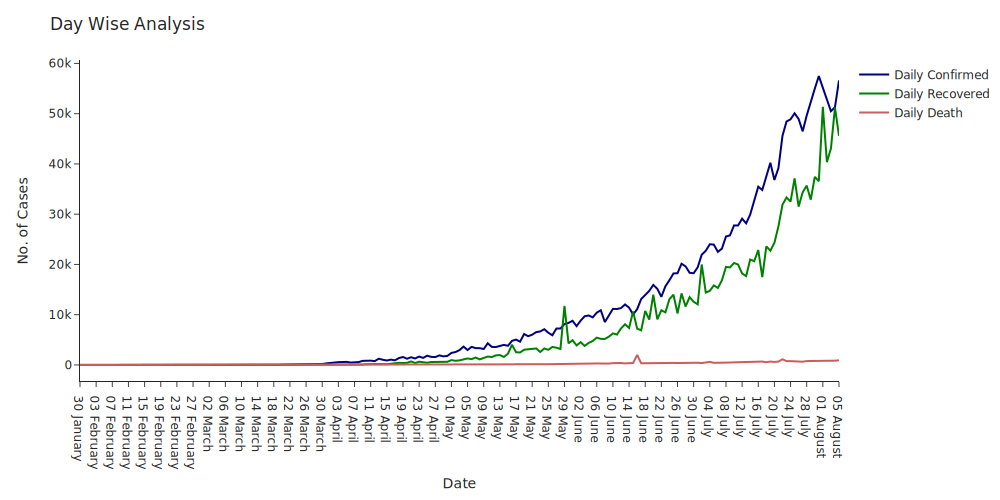

In [34]:
fig = px.line(color_discrete_sequence=[confirmed_color],template='simple_white')
fig.add_scatter(x=timeseries['date'],y=timeseries['dailyconfirmed'],name='Daily Confirmed',marker={'color': confirmed_color,'opacity': 0.6,'colorscale': 'Viridis'},)
fig.add_scatter(x=timeseries['date'],y=timeseries['dailyrecovered'],name='Daily Recovered',marker={'color': recovered_color,'opacity': 0.6,'colorscale': 'Viridis'},)
fig.add_scatter(x=timeseries['date'],y=timeseries['dailydeceased'],name='Daily Death',marker={'color': death_color,'opacity': 0.6,'colorscale': 'Viridis'})
fig.update_layout(title='Day Wise Analysis', xaxis_title="Date", yaxis_title="No. of Cases")
fig.show()
fig.show('svg',height = 500, width = 1000) #static image


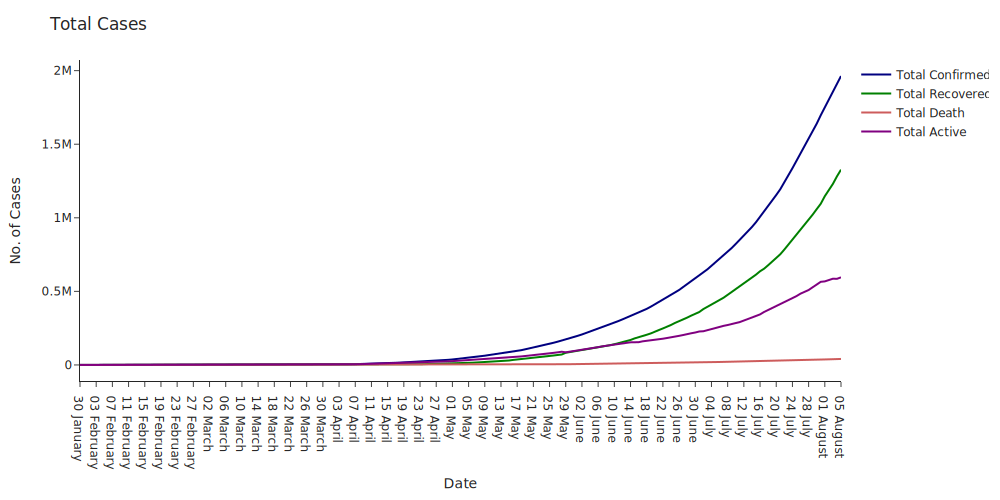

In [35]:
timeseries['totalactive'] = timeseries.totalconfirmed-timeseries.totalrecovered-timeseries.totaldeceased
fig = px.line(color_discrete_sequence=[confirmed_color],template='simple_white')
fig.add_scatter(x=timeseries['date'],y=timeseries['totalconfirmed'],name='Total Confirmed',marker={'color': confirmed_color,'opacity': 0.6,'colorscale': 'Viridis'},)
fig.add_scatter(x=timeseries['date'],y=timeseries['totalrecovered'],name='Total Recovered',marker={'color': recovered_color,'opacity': 0.6,'colorscale': 'Viridis'},)
fig.add_scatter(x=timeseries['date'],y=timeseries['totaldeceased'],name='Total Death',marker={'color': death_color,'opacity': 0.6,'colorscale': 'Viridis'})
fig.add_scatter(x=timeseries['date'],y=timeseries['totalactive'],name='Total Active',marker={'color': active_color,'opacity': 0.6,'colorscale': 'Viridis'})
fig.update_layout(title='Total Cases', xaxis_title="Date", yaxis_title="No. of Cases")
fig.show()
fig.show('svg',height = 500, width = 1000) #static image


## Top21 District Affected

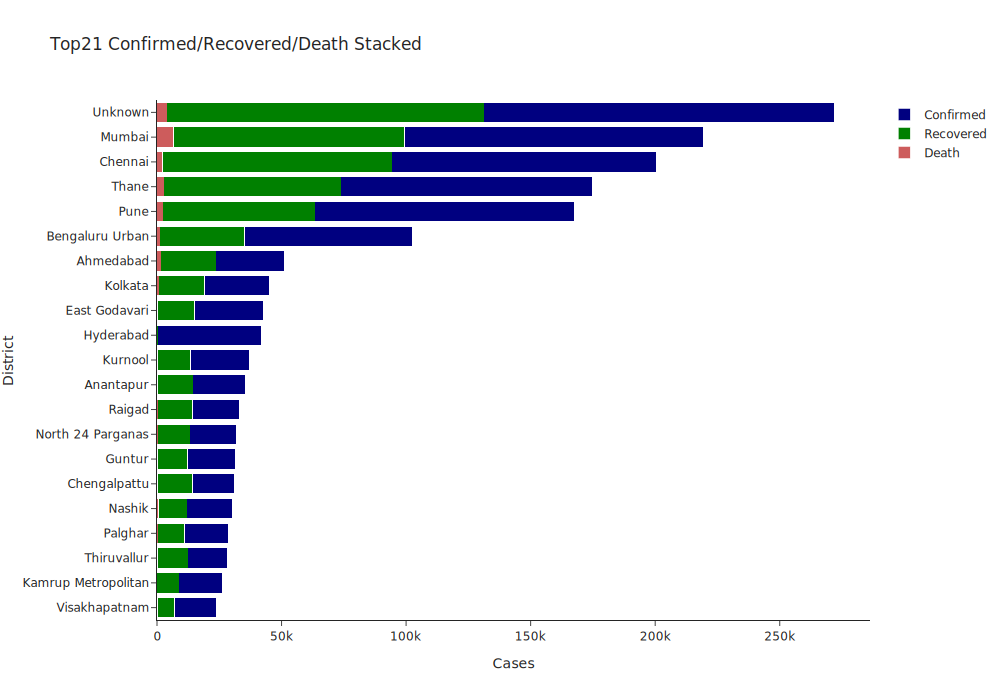

In [36]:
temp = district_wise.sort_values('Confirmed').tail(21)
fig = go.Figure(data=[
    go.Bar(name='Death', y=temp['District'], x=temp['Death'].head(21),orientation='h',marker_color=death_color),
    go.Bar(name='Recovered', y=temp['District'], x=temp['Recovered'].head(21),orientation='h',marker_color=recovered_color),
    go.Bar(name='Confirmed', y=temp['District'], x=temp['Confirmed'].head(21),orientation='h',marker_color=confirmed_color)
])
fig.update_layout(barmode='stack',title='Top21 Confirmed/Recovered/Death Stacked', xaxis_title="Cases", yaxis_title="District", 
                      yaxis_categoryorder = 'total ascending',
                     template='simple_white')
fig.show() #Here Unknown is Delhi
fig.show('svg',height = 700, width = 1000) #static image


## District Wise Conditional Formatting(Top30)

In [37]:
district_wise = district_wise[district_wise['State/UT']!='State Unassigned']
district_wise.sort_values('Confirmed', ascending= False).head(30).fillna(0).style\
                        .background_gradient(cmap='Blues_r',subset=["Confirmed"])\
                        .background_gradient(cmap='Greens_r',subset=["Recovered"])\
                        .background_gradient(cmap='Reds_r',subset=["Death"])\
                        .background_gradient(cmap='pink_r',subset=["Active"])

,State/UT,District,Confirmed,Recovered,Active,Death
160,Delhi,Unknown,140743,127124,9561,4058
350,Maharashtra,Mumbai,120150,92659,20546,6648
616,Tamil Nadu,Chennai,106096,92128,11723,2245
360,Maharashtra,Pune,104353,60857,41000,2496
367,Maharashtra,Thane,100875,70983,27012,2879
289,Karnataka,Bengaluru Urban,67425,33932,32314,1178
579,Telangana,Hyderabad,41449,305,41121,23
8,Andhra Pradesh,East Godavari,27580,14792,12583,205
170,Gujarat,Ahmedabad,27434,22152,3660,1622
758,West Bengal,Kolkata,25882,18109,6886,887


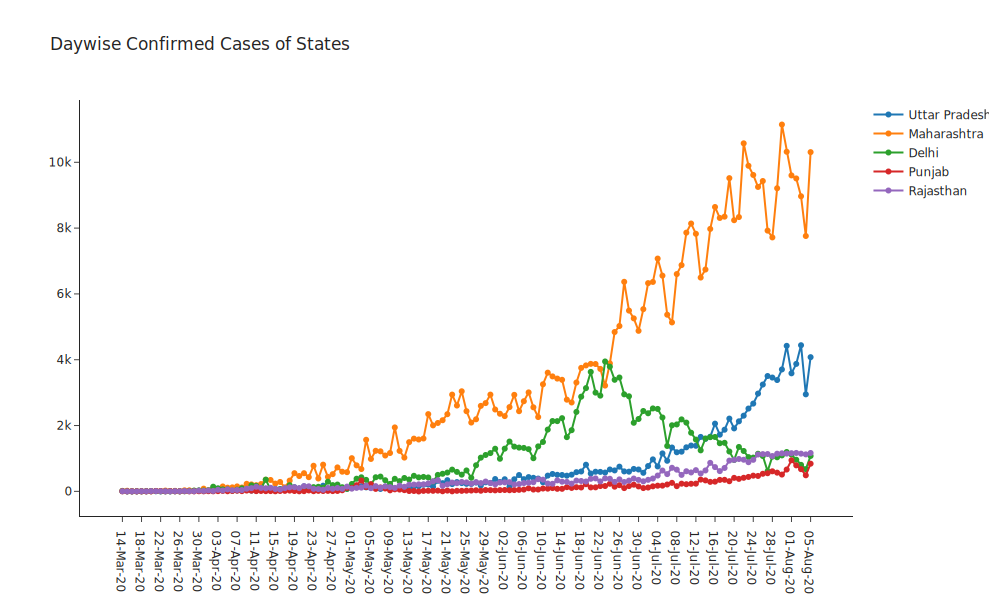

In [39]:
temp = pd.read_csv('https://api.covid19india.org/csv/latest'
                                '/state_wise_daily.csv')
temp = temp[temp['Status']=='Confirmed']
fig = go.Figure()
# fig.add_trace(go.Scatter(y=temp['TT'], x=temp['Date'],
#                     mode='lines+markers',name='Total'))
fig.add_trace(go.Scatter(y=temp['UP'], x=temp['Date'],
                    mode='lines+markers',name='Uttar Pradesh'))
fig.add_trace(go.Scatter(y=temp['MH'], x=temp['Date'],
                    mode='lines+markers',name='Maharashtra'))
fig.add_trace(go.Scatter(y=temp['DL'], x=temp['Date'],
                    mode='lines+markers',name='Delhi'))
fig.add_trace(go.Scatter(y=temp['PB'], x=temp['Date'],
                    mode='lines+markers',name='Punjab'))
fig.add_trace(go.Scatter(y=temp['RJ'], x=temp['Date'],
                    mode='lines+markers',name='Rajasthan'))
fig.update_layout(title_text="Daywise Confirmed Cases of States",
                  template='simple_white',height=700)
fig.show()
fig.show('svg',height = 600, width = 1000) #static image


In [40]:
temp = pd.read_csv('https://api.covid19india.org/csv/latest'
                                '/state_wise_daily.csv')
temp = temp[temp['Status']=='Confirmed']
temp['TTtotal'] = temp['TT'].cumsum()
temp['UPtotal'] = temp['UP'].cumsum()
temp['DLtotal'] = temp['DL'].cumsum()
temp['GJtotal'] = temp['GJ'].cumsum()
temp['PBtotal'] = temp['PB'].cumsum()
temp['RJtotal'] = temp['RJ'].cumsum()
temp['7dyMnUP'] = temp.UPtotal.rolling(7).mean().fillna(0).astype(int)
temp['7dyMnDL'] = temp.DLtotal.rolling(7).mean().fillna(0).astype(int)
temp['7dyMnGJ'] = temp.GJtotal.rolling(7).mean().fillna(0).astype(int)
temp['7dyMnPB'] = temp.PBtotal.rolling(7).mean().fillna(0).astype(int)
temp['7dyMnRJ'] = temp.RJtotal.rolling(7).mean().fillna(0).astype(int)
temp['7dyMnTT'] = temp.TTtotal.rolling(7).mean().fillna(0).astype(int)

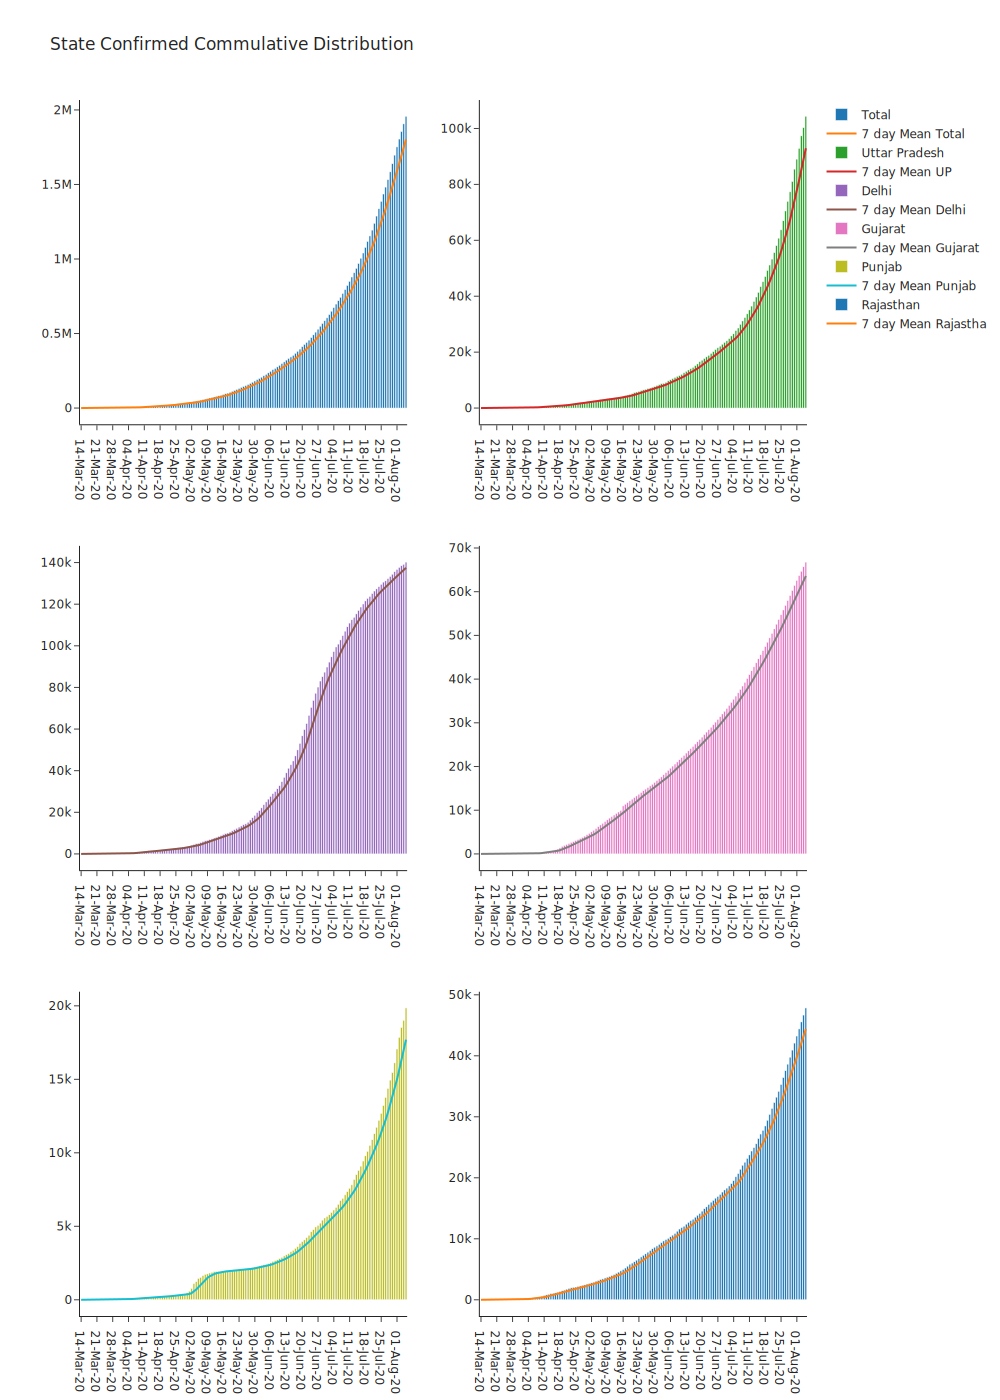

In [41]:
fig1 = make_subplots(rows=3, cols=2, shared_xaxes=False)
fig1.add_trace(go.Bar(x=temp['Date'], y=temp['TTtotal'],name='Total'),1,1)
fig1.add_trace(go.Scatter(x=temp['Date'], y=temp['7dyMnTT'], name="7 day Mean Total"), row=1, col=1)
fig1.add_trace(go.Bar(x=temp['Date'], y=temp['UPtotal'],name='Uttar Pradesh'),1,2)
fig1.add_trace(go.Scatter(x=temp['Date'], y=temp['7dyMnUP'], name="7 day Mean UP"), row=1, col=2)
fig1.add_trace(go.Bar(x=temp['Date'], y=temp['DLtotal'],name='Delhi'),2,1)
fig1.add_trace(go.Scatter(x=temp['Date'], y=temp['7dyMnDL'], name="7 day Mean Delhi"), row=2, col=1)
fig1.add_trace(go.Bar(x=temp['Date'], y=temp['GJtotal'],name='Gujarat'),2,2)
fig1.add_trace(go.Scatter(x=temp['Date'], y=temp['7dyMnGJ'], name="7 day Mean Gujarat"), row=2, col=2)
fig1.add_trace(go.Bar(x=temp['Date'], y=temp['PBtotal'],name='Punjab'),3,1)
fig1.add_trace(go.Scatter(x=temp['Date'], y=temp['7dyMnPB'], name="7 day Mean Punjab"), row=3, col=1)
fig1.add_trace(go.Bar(x=temp['Date'], y=temp['RJtotal'],name='Rajasthan'),3,2)
fig1.add_trace(go.Scatter(x=temp['Date'], y=temp['7dyMnRJ'], name="7 day Mean Rajasthan"), row=3, col=2)
fig1.update_layout(template='simple_white',height = 1500,
                   title='State Confirmed Commulative Distribution')#showlegend=False,
fig1.show()
fig1.show('svg',height = 1400, width = 1000) #static image


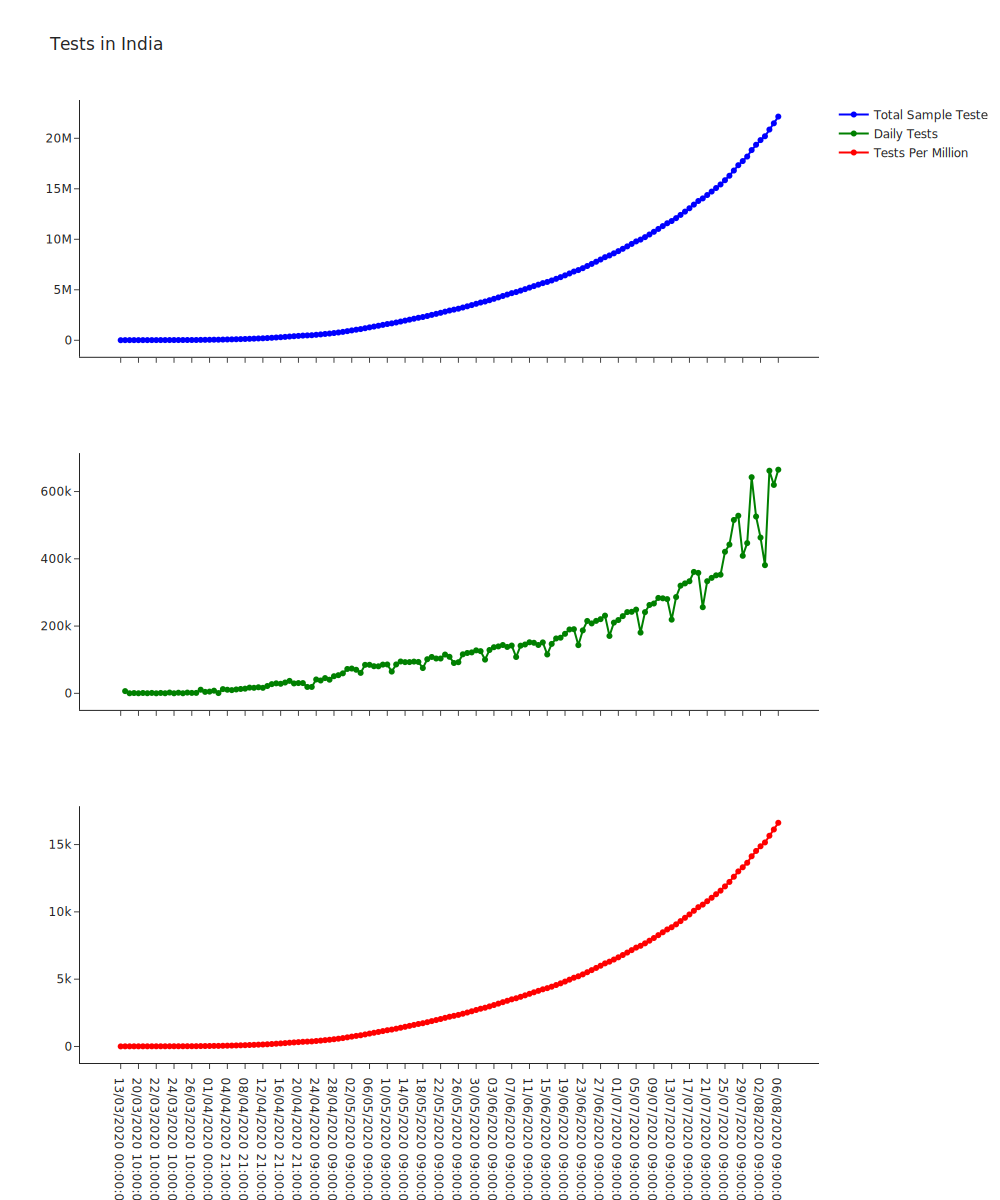

In [42]:
fig = make_subplots(rows=3, cols=1,shared_xaxes=True)
fig.add_trace(go.Scatter(x=tests['updatetimestamp'], y=tests['totalsamplestested'],mode='lines+markers',
                         name='Total Sample Tested',marker_color='blue'), row=1, col=1)
fig.add_trace(go.Scatter(x=tests['updatetimestamp'], y=tests['totalsamplestested'].diff(),mode='lines+markers',
                         name='Daily Tests',marker_color='green'), row=2, col=1)
fig.add_trace(go.Scatter(x=tests['updatetimestamp'], y=tests['testspermillion'],mode='lines+markers',
                         name='Tests Per Million',marker_color='red'), row=3, col=1)
fig.update_layout(template='simple_white',height = 1000,
                   title='Tests in India')
fig.show()
fig.show('svg',height = 1200, width = 1000) #static image


### Thank you😋